In [1]:
# 库文件
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
# 设置中文字体
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=12)  # 替换为你的中文字体文件路径


In [2]:
# 读取Excel文件
excel_path = f'C:\\Users\\haokw\\Documents\\GitHub\\gaolu\\MPC\\高炉\\0数据处理\\简单插值\\原始数据-时间戳.xlsx'
df_sheet = pd.read_excel(excel_path, sheet_name='Sheet2') 
print(df_sheet.info())
print(df_sheet.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7398 entries, 0 to 7397
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   时间戳     7398 non-null   int64  
 1   SI      7398 non-null   float64
 2   铁口1温度   7398 non-null   float64
 3   富氧流量    7398 non-null   float64
 4   冷风流量    7398 non-null   float64
 5   热风压力    7398 non-null   float64
 6   热风温度    7398 non-null   float64
 7   鼓风湿度    7398 non-null   float64
 8   设定喷煤量   7398 non-null   float64
 9   上小时喷煤量  7398 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 578.1 KB
None
Index(['时间戳', 'SI', '铁口1温度', '富氧流量', '冷风流量', '热风压力', '热风温度', '鼓风湿度', '设定喷煤量',
       '上小时喷煤量'],
      dtype='object')


In [3]:
# 定义输入输出参数
input_term = ['富氧流量', '冷风流量', '热风压力', '热风温度', '鼓风湿度', '设定喷煤量', '上小时喷煤量']
output_term = ['铁口1温度', 'SI']
time_term= '时间戳'


C:\Users\haokw\AppData\Local\Temp\ipykernel_16748\693723773.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_16748\693723773.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\AppData\Local\Temp\ipykernel_16748\693723773.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[idx] = interpolated_value
C:\Users\haokw\A

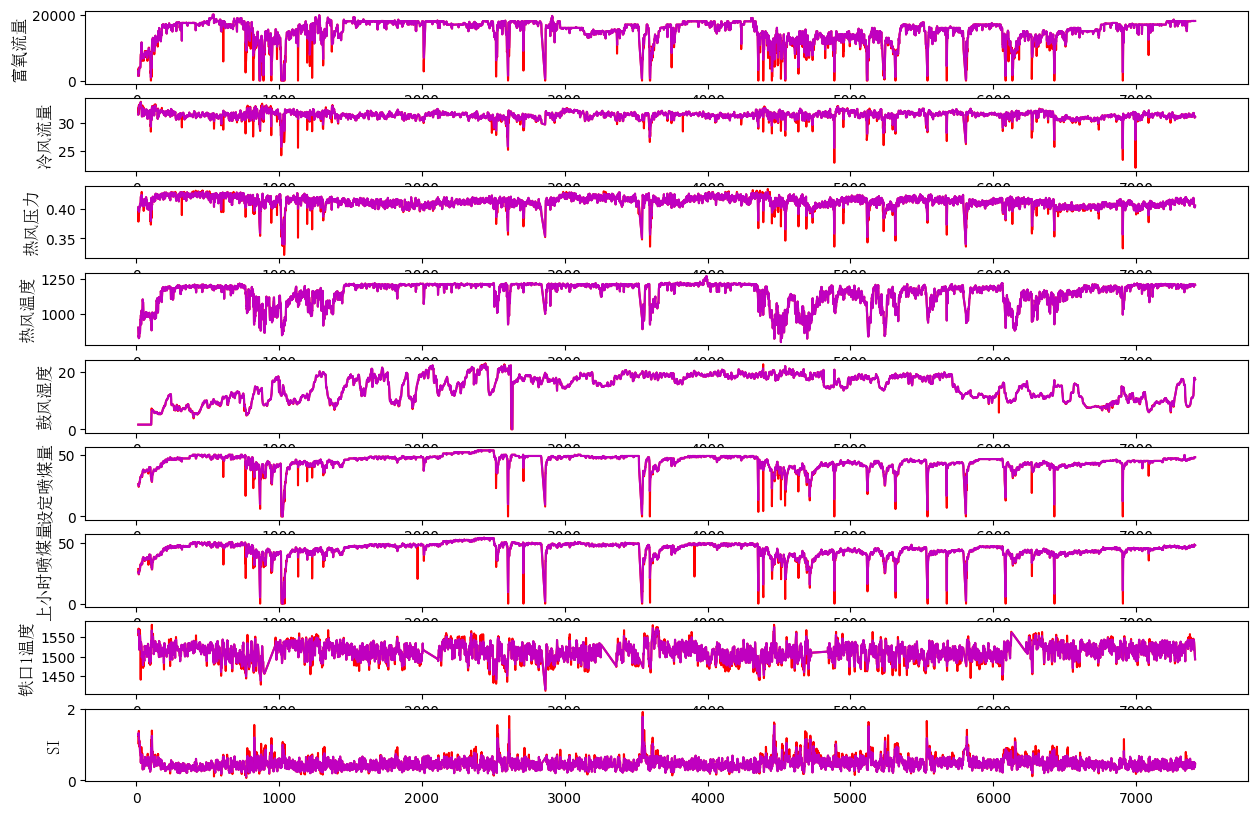

In [5]:
# 异常数据处理-处理前后对比
# 创建数据框副本以避免修改原始数据
df_sheet_process = df_sheet.copy()
# 定义一个函数，用前后两个值的差值按照距离进行加权替换异常值
def replace_outliers_with_weighted_diff(x, y):
    # 计算列的中位数
    median_value = y.median()
    # 检测异常值的索引
    outliers_index = (y - median_value).abs() > 1.5 * y.std()  # 使用标准差作为阈值
    
    # 遍历异常值的索引
    for idx in outliers_index[outliers_index].index:
        # 获取异常值前一个和后一个值的索引
        prev_idx = idx - 1 if idx - 1 >= 0 else idx
        next_idx = idx + 1 if idx + 1 < len(y) else idx
        # 计算当前 x 与前后两个 x 的距离
        dist_prev = abs(x[idx] - x[prev_idx])
        dist_next = abs(x[next_idx] - x[idx])
        total_dist = dist_prev + dist_next
        # 计算权重
        weight_prev = dist_next / total_dist
        weight_next = dist_prev / total_dist
        # 计算前后两个值的差值
        diff = y[next_idx] - y[prev_idx]
        # 根据权重进行插值
        interpolated_value = y[prev_idx] + weight_prev * diff
        # 用插值结果替代异常值
        y[idx] = interpolated_value




# 画出数据
def plot_subplot(data_x,data_y_yuan,data_y,column):
    plt.plot(data_x,data_y_yuan,'r-')
    plt.plot(data_x,data_y,'m-')
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签
    # 使用中文标签


# 对指定列应用替代异常值的函数
# 对指定列应用替代异常值的函数
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[0]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[1]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[2]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[4]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[5]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[input_term[6]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[output_term[0]])
replace_outliers_with_weighted_diff(df_sheet_process['时间戳'], df_sheet_process[output_term[1]])

plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet[column].values,df_sheet_process[column].values,column)




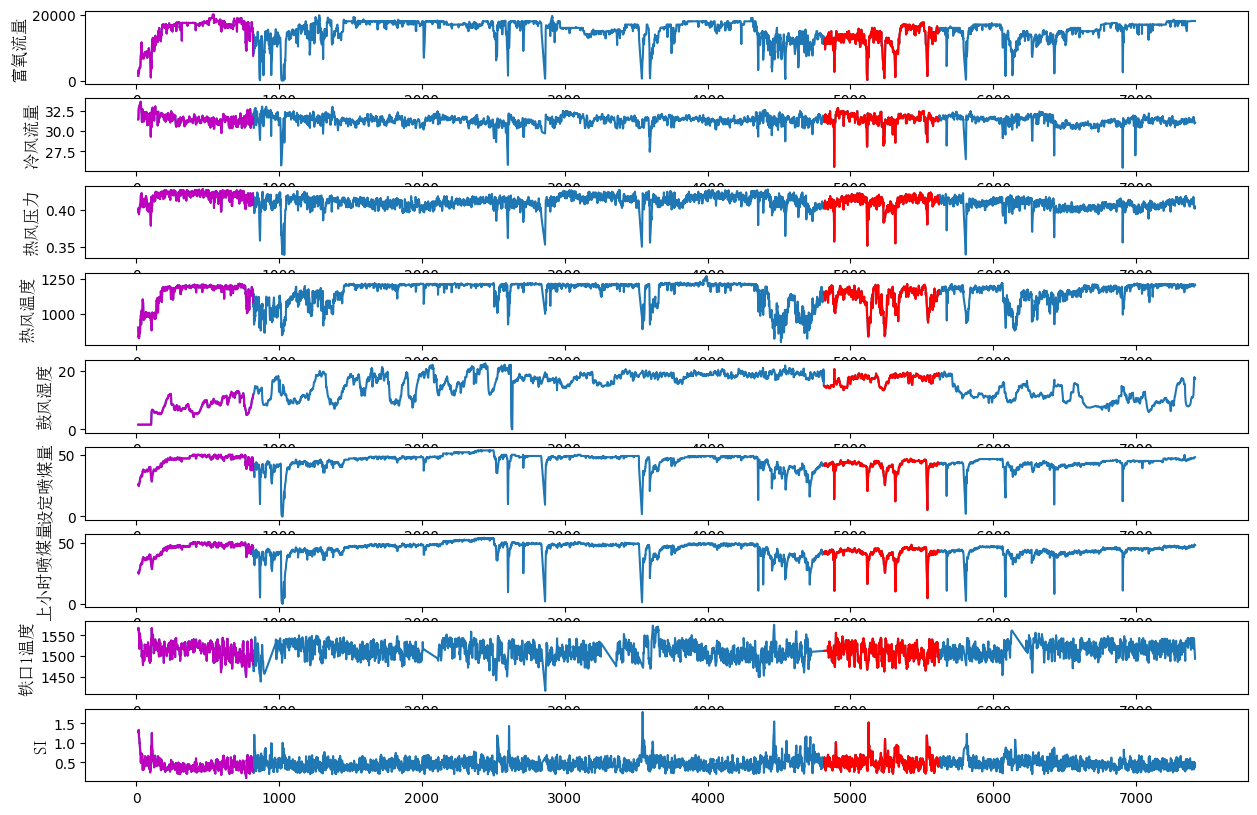

In [6]:
# 画出选取的数据
def plot_subplot(data_x,data_y,column,index_predict,index_gaolu):
    plt.plot(data_x,data_y,'-')
    plt.plot(data_x[index_gaolu],data_y[index_gaolu],'m-')
    plt.plot(data_x[index_predict],data_y[index_predict],'r-')
    
    # plt.xlabel(time_term, fontproperties=font)  # 使用中文标签
    plt.ylabel(column, fontproperties=font)  # 使用中文标签

length1 = 804
start1 = 0
length2 = 804
start2 = 4800


index_gaolu   = range(start1, start1+length1+1, 1)
index_predict     = range(start2, start2+length2+1, 1)
# index = range(1, 7572, 1)


plt.figure(figsize=(15, 10))
for idx, column in enumerate(input_term+output_term):
    plt.subplot(len(input_term+output_term), 1, idx+1)
    plot_subplot(df_sheet_process[time_term].values,df_sheet_process[column].values,column,index_predict,index_gaolu)


In [7]:
# 数据归一化、逆归一化
from sklearn.preprocessing import MinMaxScaler

# 将数据存储为字典，每个键对应一列数据
original_data_dict = {
    input_term[0]:   df_sheet_process[input_term[0]].values,
    input_term[1]:   df_sheet_process[input_term[1]].values,
    input_term[2]:   df_sheet_process[input_term[2]].values,
    input_term[3]:   df_sheet_process[input_term[3]].values,
    input_term[4]:   df_sheet_process[input_term[4]].values,
    input_term[5]:   df_sheet_process[input_term[5]].values,
    input_term[6]:   df_sheet_process[input_term[6]].values,
    output_term[0]:  df_sheet_process[output_term[0]].values,
    output_term[1]:  df_sheet_process[output_term[1]].values
}

# 初始化缩放器
scalers = {}

# 进行拟合
for column, data in original_data_dict.items():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(data.reshape(-1, 1))  # 保证数据是列向量
    scalers[column] = scaler

# 进行归一化
normalized_data_dict = {}
for column, scaler in scalers.items():
    normalized_data_dict[column] = scaler.transform(original_data_dict[column].reshape(-1, 1)).flatten()

# 进行反归一化
original_data_dict = {}
for column, scaler in scalers.items():
    original_data_dict[column] = scaler.inverse_transform(normalized_data_dict[column].reshape(-1, 1)).flatten()


In [8]:
# 组合训练数据--拆分训练、测试集
train_size = 0.7
val_size = 0.15
test_size = 0.15
# 定义时间步数和特征数
time_steps = 8
features = 9
def make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,y1_data,y2_data,test_size):
    # 假设您有六个时间序列数据
    # u1_data, u2_data, u3_data, u4_data, y1_data, y2_data 是形状为 (800, 1) 的 NumPy 数组

    # 堆叠输入和输出数据
    X = np.column_stack((u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data, y1_data, y2_data))
    y = np.column_stack((y1_data, y2_data))
    # print('X',X.shape)



    # 创建空数组用于存储新的输入和输出数据
    X_modified = []
    y_modified = []
    
    # 生成新的输入和输出数据
    for i in range(len(X) - time_steps):
        X_sample = X[i:i + time_steps, :]
        y_sample = y[i + time_steps, :]  # 取每个序列的第11个时刻作为输出
        # print(i,i + time_steps,i + time_steps)
        X_modified.append(X_sample)
        y_modified.append(y_sample)

    # 将列表转换为 NumPy 数组
    X_modified = np.array(X_modified)
    y_modified = np.array(y_modified)

    # 打印新数据的形状
    print("Modified Input Shape:", X_modified.shape)
    print("Modified Output Shape:", y_modified.shape)

    isShuffle = True
    # isShuffle = False

    X_train, X_test, y_train, y_test = train_test_split(X_modified, y_modified, 
                                                        test_size=test_size, 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    # 将剩余的70%训练数据再次拆分成训练数据和验证数据（20%验证数据，50%训练数据）
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                        test_size=val_size/(train_size+val_size), 
                                                        random_state=42, 
                                                        shuffle=isShuffle)

    print('训练数量：',X_train.shape,y_train.shape)
    print('验证数量：',X_val.shape,y_val.shape)
    print('测试数量：',X_test.shape,y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test


In [9]:
# 高炉模型列数据
u1_data = normalized_data_dict[input_term[0]][index_gaolu]
u2_data = normalized_data_dict[input_term[1]][index_gaolu]
u3_data = normalized_data_dict[input_term[2]][index_gaolu]
u4_data = normalized_data_dict[input_term[3]][index_gaolu]
u5_data = normalized_data_dict[input_term[4]][index_gaolu]
u6_data = normalized_data_dict[input_term[5]][index_gaolu]
u7_data = normalized_data_dict[input_term[6]][index_gaolu]
y1_data = normalized_data_dict[output_term[0]][index_gaolu]
y2_data = normalized_data_dict[output_term[1]][index_gaolu]
num_samples = y2_data.shape[0]

print('高炉模型数据')
X_gaolu_train, X_gaolu_val, X_gaolu_test,\
y_gaolu_train, y_gaolu_val, y_gaolu_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            test_size=test_size)



高炉模型数据
Modified Input Shape: (797, 8, 9)
Modified Output Shape: (797, 2)
训练数量： (557, 8, 9) (557, 2)
验证数量： (120, 8, 9) (120, 2)
测试数量： (120, 8, 9) (120, 2)


In [10]:
# 预测模型列数据
u1_data = normalized_data_dict[input_term[0]][index_predict]
u2_data = normalized_data_dict[input_term[1]][index_predict]
u3_data = normalized_data_dict[input_term[2]][index_predict]
u4_data = normalized_data_dict[input_term[3]][index_predict]
u5_data = normalized_data_dict[input_term[4]][index_predict]
u6_data = normalized_data_dict[input_term[5]][index_predict]
u7_data = normalized_data_dict[input_term[6]][index_predict]
y1_data = normalized_data_dict[output_term[0]][index_predict]
y2_data = normalized_data_dict[output_term[1]][index_predict]
num_samples = y2_data.shape[0]


# print('Oxygen_enrich_rate:', u1_data.shape)
# print('Set_coal_amount:', u2_data.shape)
# print('hot_wind_temp:', u3_data.shape)
# print('hot_wind_presure:', u4_data.shape)
# print('temp:', y1_data.shape)
# print('Si_percent:', y2_data.shape)
# print(num_samples)

X_predict_train, X_predict_val, X_predict_test,\
y_predict_train, y_predict_val, y_predict_test = make_data(u1_data,u2_data,u3_data,u4_data,u5_data,u6_data,u7_data,
                                                            y1_data,y2_data,
                                                            test_size=test_size)


Modified Input Shape: (797, 8, 9)
Modified Output Shape: (797, 2)
训练数量： (557, 8, 9) (557, 2)
验证数量： (120, 8, 9) (120, 2)
测试数量： (120, 8, 9) (120, 2)


In [11]:
# plt.plot(u1_data)
# plt.plot(u2_data)
# plt.plot(u3_data)
# plt.plot(u4_data)
# plt.plot(y1_data)
# plt.plot(y2_data)


In [12]:
# 定义LSTM模型
import torch
import torch.nn as nn
import torch.optim as optim

class MyRNNModel(torch.nn.Module):
    def __init__(self,features_size,hidden_size,isbidirectional):
        super(MyRNNModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=features_size,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=isbidirectional
        )
        if isbidirectional:
            self.fc = nn.Linear(2 * hidden_size, 2)
        else:
            self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        
        last_lstm_output = lstm_out[:, -1, :]
        # print(last_lstm_output)
        output = self.fc(last_lstm_output)
        
        return output

    def custom_loss(self, y_true, y_pred):
        squared_diff = torch.pow(y_true - y_pred, 2)
        sum_squared_diff = torch.sum(squared_diff)
        mse = sum_squared_diff / len(y_true)
        return mse



    def my_fit(self, 
                X_train, y_train, 
                X_val, y_val, 
                train_loss_list,val_loss_list,
                epochs=1, batch_size=32, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)


        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                x_batch = torch.tensor(X_train[i:i+batch_size], dtype=torch.float32)
                y_batch = torch.tensor(y_train[i:i+batch_size], dtype=torch.float32)

                optimizer.zero_grad()
                y_pred = self(x_batch)
                loss = self.custom_loss(y_batch, y_pred)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            average_epoch_train_loss = epoch_loss / (len(X_train) / batch_size)
            # 验证集评估
            self.eval()
            with torch.no_grad():
                val_loss = 0
                for i in range(0, len(X_val), batch_size):
                    x_batch_val = torch.tensor(X_val[i:i+batch_size], dtype=torch.float32)
                    y_batch_val = torch.tensor(y_val[i:i+batch_size], dtype=torch.float32)

                    y_pred_val = self(x_batch_val)
                    val_loss += self.custom_loss(y_batch_val, y_pred_val).item()

                average_epoch_val_loss = val_loss / (len(X_train) / batch_size)

            print(f'第 {epoch + 1}/{epochs} 轮, 训练误差: {average_epoch_train_loss:.4f}, 验证误差: {average_epoch_val_loss:.4f}', end='\r')
            train_loss_list.append(average_epoch_train_loss)
            val_loss_list.append(average_epoch_val_loss)

        return train_loss_list,val_loss_list
    
    

    def my_predict(self, X_test):
        # 设置模型为评估模式，这会关闭 dropout 等层
        self.eval()
        # 将输入数据转换为张量，并设置 requires_grad=True
        x_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)
        
        # 获取模型的预测输出
        y_pred = self(x_tensor)
        # 保留预测值的梯度信息
        y_pred.retain_grad()
        # 返回预测结果和包含梯度信息的张量
        return y_pred[:,0].detach().numpy(),y_pred[:,1].detach().numpy()


In [13]:
epoch_once_time = 200


In [14]:
# 建立高炉模型实例
features_size = 9
hidden_size = 16
# 设置随机种子
model_gaolu = MyRNNModel(features_size = features_size, 
                        hidden_size = hidden_size,
                        isbidirectional=False)
epoch_sum_gaolu = 0
gaolu_train_loss_list = []
gaolu_val_loss_list = []



第 2/200 轮, 训练误差: 0.1554, 验证误差: 0.0181

第 200/200 轮, 训练误差: 0.0163, 验证误差: 0.0043
epoch_sum: 200


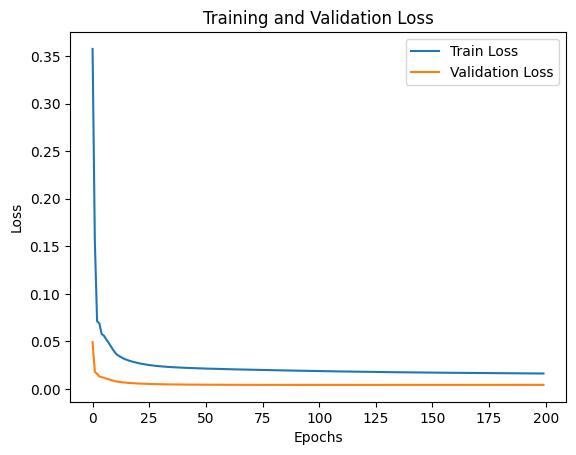

In [15]:
# 高炉模型训练
epoch_once = epoch_once_time
epoch_sum_gaolu = epoch_sum_gaolu + epoch_once
gaolu_train_loss_list,gaolu_val_loss_list = model_gaolu.my_fit(X_gaolu_train, y_gaolu_train,
                                    X_gaolu_val, y_gaolu_val, 
                                    gaolu_train_loss_list, gaolu_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=64,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_gaolu)

# 绘制训练和验证损失曲线
plt.plot(gaolu_train_loss_list, label='Train Loss')
plt.plot(gaolu_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE:  铁口1温度: 8.1385 , SI: 0.0661 
MAPE:  铁口1温度: 0.4260% , SI: 12.5618%
MRE :  铁口1温度: 0.0043  , SI: 0.1256 


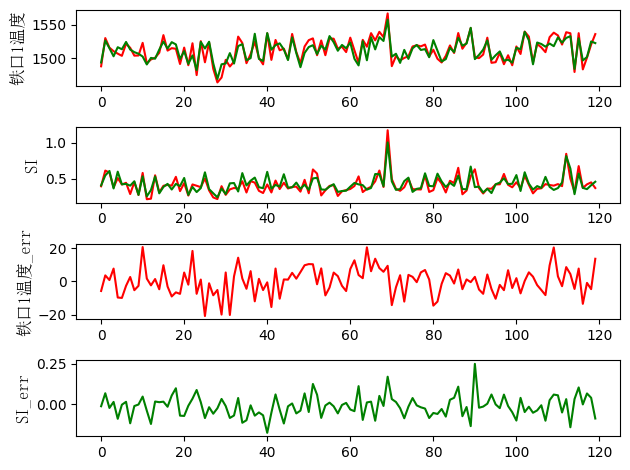

In [16]:
# 高炉模型预测
y_pred_0,y_pred_1  = model_gaolu.my_predict(X_gaolu_test)
# 计算 RMSE、MRE
y_test = y_gaolu_test




y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1))


mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
mape_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100

# 打印结果

print(f"RMSE:  {output_term[0]}: {rmse_0:.4f} , {output_term[1]}: {rmse_1:.4f} ")
print(f"MAPE:  {output_term[0]}: {mape_0:.4f}% , {output_term[1]}: {mape_1:.4f}%")
print(f"MRE :  {output_term[0]}: { mre_0:.4f}  , {output_term[1]}: { mre_1:.4f} ")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

# print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
# print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')
plt.ylabel(output_term[1]+'_err', fontproperties=font)  # 使用中文标签


plt.tight_layout()
plt.show()



In [17]:
# 创建预测模型实例
features_size = 9
hidden_size_predict = 16
# 设置随机种子
model = MyRNNModel(features_size = features_size, 
                    hidden_size = hidden_size_predict,
                    isbidirectional=True)
epoch_sum_predict = 0
predict_train_loss_list = []
predict_val_loss_list = []



第 200/200 轮, 训练误差: 0.0234, 验证误差: 0.0055
epoch_sum: 0


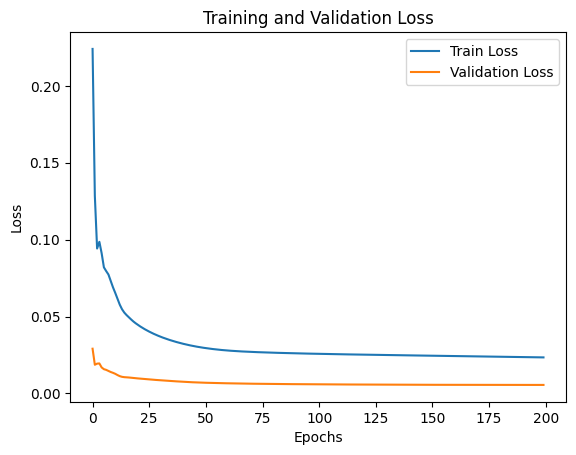

In [18]:
# 预测模型训练
epoch_once = epoch_once_time
epoch_sum = epoch_sum_predict + epoch_once
predict_train_loss_list, predict_val_loss_list = model.my_fit(X_predict_train, y_predict_train,
                                    X_predict_val, y_predict_val, 
                                    predict_train_loss_list, predict_val_loss_list,
                                    epochs=epoch_once, 
                                    batch_size=128,
                                    lr = 0.002)

print('\nepoch_sum:',epoch_sum_predict)


# 绘制训练和验证损失曲线
plt.plot(predict_train_loss_list, label='Train Loss')
plt.plot(predict_val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


RMSE:  铁口1温度: 8.6692 , SI: 0.0806 
MAPE:  铁口1温度: 0.4292% , SI: 13.8558%
MRE :  铁口1温度: 0.0043  , SI: 0.1386 


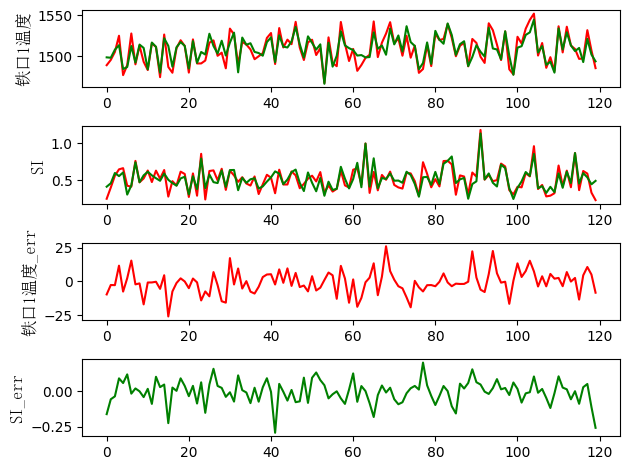

In [19]:
# 预测模型预测
y_pred_0,y_pred_1  = model.my_predict(X_predict_test)

# 计算 RMSE、MRE
y_test = y_predict_test
# y_test = y_test[:-1]
# y_pred_0 = y_pred_0[1:]
# y_pred_1 = y_pred_1[1:]


y_test_0 = scalers[output_term[0]].inverse_transform((y_test[:, 0]).reshape(-1, 1)).flatten()
y_test_1 = scalers[output_term[1]].inverse_transform((y_test[:, 1]).reshape(-1, 1)).flatten()
y_pred_0_inverse_transform = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_inverse_transform = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

rmse_0 = np.sqrt(mean_squared_error(y_test_0, y_pred_0_inverse_transform))
rmse_1 = np.sqrt(mean_squared_error(y_test_1, y_pred_1_inverse_transform))

# 计算 
mre_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0))
mre_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1))


mape_0 = np.mean(np.abs((y_test_0 - y_pred_0_inverse_transform) / y_test_0)) * 100
mape_1 = np.mean(np.abs((y_test_1 - y_pred_1_inverse_transform) / y_test_1)) * 100

# 打印结果
print(f"RMSE:  {output_term[0]}: {rmse_0:.4f} , {output_term[1]}: {rmse_1:.4f} ")
print(f"MAPE:  {output_term[0]}: {mape_0:.4f}% , {output_term[1]}: {mape_1:.4f}%")
print(f"MRE :  {output_term[0]}: { mre_0:.4f}  , {output_term[1]}: { mre_1:.4f} ")

# plot_hit_rate_curve(y_test, y_pred_0, y_pred_1)


output0 = y_test_0 - y_pred_0_inverse_transform
output1 = y_test_1 - y_pred_1_inverse_transform

# print(f"误差分析0:平均值:{output0.std():.4f},方差:{output0.mean():.4f}")
# print(f"误差分析1:平均值:{output1.std():.4f},方差:{output1.mean():.4f}")


plt.subplot(4, 1, 1)
plt.plot(y_test_0,'r')
plt.plot(y_pred_0_inverse_transform,'g')
plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 2)
plt.plot(y_test_1,'r')
plt.plot(y_pred_1_inverse_transform,'g')
plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
#

plt.subplot(4, 1, 3)
plt.plot(output0,'r-')
plt.ylabel(output_term[0]+'_err', fontproperties=font)  # 使用中文标签


plt.subplot(4, 1, 4)
plt.plot(output1,'g-')
plt.ylabel(output_term[1]+'_err', fontproperties=font)  # 使用中文标签


plt.tight_layout()
plt.show()


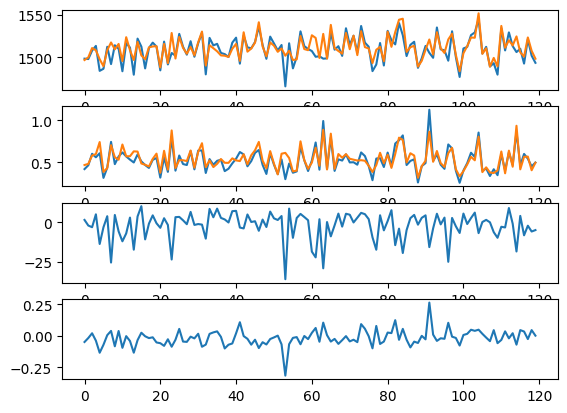

In [20]:
y_pred_0,y_pred_1  = model.my_predict(X_predict_test)
y_pred_0_predict = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_predict = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

y_pred_0,y_pred_1  = model_gaolu.my_predict(X_predict_test)
y_pred_0_gaolu = scalers[output_term[0]].inverse_transform((y_pred_0).reshape(-1, 1)).flatten()
y_pred_1_gaolu = scalers[output_term[1]].inverse_transform((y_pred_1).reshape(-1, 1)).flatten()

plt.subplot(4, 1, 1)
plt.plot(y_pred_0_predict)
plt.plot(y_pred_0_gaolu)

plt.subplot(4, 1, 2)
plt.plot(y_pred_1_predict)
plt.plot(y_pred_1_gaolu)

plt.subplot(4, 1, 3)
plt.plot(y_pred_0_predict-y_pred_0_gaolu)

plt.subplot(4, 1, 4)
plt.plot(y_pred_1_predict-y_pred_1_gaolu)



In [29]:
iscontrol = True
# iscontrol = False


In [30]:
# 自定义预测
model_predict = model
hidden_size = hidden_size_predict
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lstm_forward(input, initial_states, w_ih, w_hh, b_ih, b_hh):
    h_0, c_0 = initial_states  # 初始状态  [b_size, hidden_size]
    b_size, seq_len, input_size = input.shape
    h_size = h_0.shape[-1]

    h_prev, c_prev = h_0, c_0

    # 使用 np.newaxis 在第一个维度上插入一个新的维度  # 使用 np.tile 在第一个维度上复制 b_size 次
    w_ih_expanded = w_ih[np.newaxis, :, :]    
    w_ih_batch = np.tile(w_ih_expanded, (b_size, 1, 1))
    w_hh_expanded = w_hh[np.newaxis, :, :]    
    w_hh_batch = np.tile(w_hh_expanded, (b_size, 1, 1))
    # print(w_ih_batch.shape)

    output_size = h_size
    output = np.zeros((b_size, seq_len, output_size))  # 初始化一个输出序列
    for t in range(seq_len):
        x = input[:, t, :]  # 当前时刻的输入向量 [b,in_size]->[b,in_size,1]
        w_times_x = np.matmul(w_ih_batch, x[:, :, np.newaxis]).squeeze(-1)   # bmm:含有批量大小的矩阵相乘
        # [b, 4*hidden_size, 1]->[b, 4*hidden_size]
        # 这一步就是计算了 Wii*xt|Wif*xt|Wig*xt|Wio*xt
        w_times_h_prev = np.matmul(w_hh_batch, h_prev[:, :, np.newaxis]).squeeze(-1)
        # [b, 4*hidden_size, hidden_size]*[b, hidden_size, 1]->[b,4*hidden_size, 1]->[b, 4*hidden_size]
        # 这一步就是计算了 Whi*ht-1|Whf*ht-1|Whg*ht-1|Who*ht-1

        # 分别计算输入门(i)、遗忘门(f)、cell门(g)、输出门(o)  维度均为 [b, h_size]
        i_t = sigmoid(w_times_x[:, :h_size] + w_times_h_prev[:, :h_size] + b_ih[:h_size] + b_hh[:h_size])  # 取前四分之一
        f_t = sigmoid(w_times_x[:, h_size:2*h_size] + w_times_h_prev[:, h_size:2*h_size]
                            + b_ih[h_size:2*h_size] + b_hh[h_size:2*h_size])
        g_t = np.tanh(w_times_x[:, 2*h_size:3*h_size] + w_times_h_prev[:, 2*h_size:3*h_size]
                            + b_ih[2*h_size:3*h_size] + b_hh[2*h_size:3*h_size])
        o_t = sigmoid(w_times_x[:, 3*h_size:] + w_times_h_prev[:, 3*h_size:]
                            + b_ih[3*h_size:] + b_hh[3*h_size:])
        c_prev = f_t * c_prev + i_t * g_t
        h_prev = o_t * np.tanh(c_prev)

        output[:, t, :] = h_prev

    return output, (np.expand_dims(h_prev, axis=0), np.expand_dims(c_prev, axis=0))  # 官方是三维，在第0维扩一维



def predict_my(data_input):

    input = data_input  # 随机初始化一个输入序列
    c_0 = np.zeros((data_input.shape[0], hidden_size))  # 初始值，不会参与训练
    h_0 = np.zeros((data_input.shape[0], hidden_size))

    output_forward, (h_n_me, c_n_me) = lstm_forward(input, (h_0, c_0), 
                                                model_predict.lstm.weight_ih_l0.detach().numpy(),
                                                model_predict.lstm.weight_hh_l0.detach().numpy(), 
                                                model_predict.lstm.bias_ih_l0.detach().numpy(), 
                                                model_predict.lstm.bias_hh_l0.detach().numpy())

    last_lstm_output_forward = output_forward[:, -1, :]

    output_backward, (h_n_me, c_n_me) = lstm_forward(input, (h_0, c_0), 
                                                model_predict.lstm.weight_ih_l0_reverse.detach().numpy(),
                                                model_predict.lstm.weight_hh_l0_reverse.detach().numpy(), 
                                                model_predict.lstm.bias_ih_l0_reverse.detach().numpy(), 
                                                model_predict.lstm.bias_hh_l0_reverse.detach().numpy())

    last_lstm_output_backward = output_backward[:, -1, :]
    # print(last_lstm_output_forward.shape)
    # print(last_lstm_output_backward.shape)
    # 最终输出
    combined_hidden = np.concatenate((last_lstm_output_forward, last_lstm_output_backward), axis=1)
    # print(combined_hidden.shape)


    output = (np.dot(combined_hidden, np.transpose(model_predict.fc.weight.detach().numpy()))
                + model_predict.fc.bias.detach().numpy()
)
    y_pred_0, y_pred_1= output[:,0],output[:,1]

    # y_pred_0 = scalers[output_term[0]].inverse_transform(np.array(y_pred_0).reshape(-1, 1)).flatten()
    # y_pred_1 = scalers[output_term[1]].inverse_transform(np.array(y_pred_1).reshape(-1, 1)).flatten()




    return y_pred_0, y_pred_1


y_pred_0, y_pred_1= predict_my(X_predict_test)


In [31]:
# 生成期望数据
Times = 100

def generate_y_aim_data(Times):

    set_y1 = np.full(Times,1500)
    set_y1[30:] = 1505
    set_y1[60:] = 1510
    set_y1[90:] = 1515
    # set_y1[70:] = 1520
    # set_y1[90:] = 1525

    set_y2 = np.full(Times,0.40)
    set_y2[15:] = 0.44
    set_y2[45:] = 0.48
    set_y2[75:] = 0.52
    # 限制设定值在 -1 到 1 之间
    # set_y1 = np.clip(set_y1, -1, 1)
    # set_y2 = np.clip(set_y2, -1, 1)


    set_y1_trans = scalers[output_term[0]].transform(set_y1.reshape(-1,1)).flatten()
    set_y2_trans = scalers[output_term[1]].transform(set_y2.reshape(-1,1)).flatten()

    return set_y1, set_y2, set_y1_trans, set_y2_trans

# # 调用示例
# set_y1, set_y2, set_y1_trans, set_y2_trans= generate_y_aim_data(Times)
# plt.plot(set_y1_trans)
# plt.plot(set_y2_trans)
# plt.title('y_sp')
# plt.show()



In [32]:
# 生成参考轨迹
def get_yr(aim_value,current_value,alpha,P):
    # 生成设定信号
    setpoint_signal = np.full(10, aim_value)
    # 初始化参数
    alpha = alpha
    y_r = np.zeros(P)
    y_r[0] = current_value
    # 模拟一阶模型
    for k in range(1,P):
        y_r[k] = alpha * y_r[k-1] + (1 - alpha) * aim_value

    # # 绘制结果
    # plt.plot(setpoint_signal, label='Setpoint Signal')
    # plt.plot(y_r,'o-', label='Output Signal (Tracked)')
    # plt.legend()
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Tracking Setpoint Signal with One-Order Model')
    # plt.show()
    return y_r
# 测试
y_r = get_yr(1,-0.5,0.667,5+1)


In [33]:
#生成控制时域的数据格式
def generate_k_data(time_steps,features):
    k_data = torch.randn(1, time_steps + 1, features).numpy().round(4)
    # k_data = np(k_data)
    print(k_data.shape)
    return k_data

# ggg = generate_k_data(time_steps,features)
# ggg



In [56]:
# 定义单时刻的MPC问题优化
def my_MPC(k_data,params,M,P,y1_aim,y2_aim,isprint):
    h1 = 1.0
    h2 = 1.0
    lamda1 = 0.001
    lamda2 = 0.001
    lamda3 = 0.001
    lamda4 = 0.001
    y1_percent = 1.0
    y2_percent = 1.0

    # 从固定格式k_data里面读取信息
    
    if isprint==1:
        print('kaishi --------------------------------------------------')
        print(k_data.round(4))
        print(k_data.shape)
        print(k_data[0,:,1])

    # 获取猜测值[U1, U2, U3, U4]
    U1, U2, U3, U4, U5, U6, U7  =params[0:M], params[M:2*M],params[2*M:3*M], params[3*M:4*M], params[4*M:5*M],params[5*M:6*M], params[6*M:7*M]

    if isprint==1:
        print( U1, U2, U3, U4, U5, U6, U7)

    
    u1   = np.concatenate((k_data[0,:,0],U1,U1[-1]*np.ones(P-M)))
    u2   = np.concatenate((k_data[0,:,1],U2,U2[-1]*np.ones(P-M)))
    u3   = np.concatenate((k_data[0,:,2],U3,U3[-1]*np.ones(P-M)))
    u4   = np.concatenate((k_data[0,:,3],U4,U4[-1]*np.ones(P-M)))
    u5   = np.concatenate((k_data[0,:,4],U5,U5[-1]*np.ones(P-M)))
    u6   = np.concatenate((k_data[0,:,5],U6,U6[-1]*np.ones(P-M)))
    u7   = np.concatenate((k_data[0,:,6],U7,U7[-1]*np.ones(P-M)))
    y1   = np.concatenate((k_data[0,:,7],np.zeros(P)))
    y2   = np.concatenate((k_data[0,:,8],np.zeros(P)))
    if isprint==1:
        print('新加入控制U与k_data拼接：')
        print(u1.round(4))
        print(u2.round(4))
        print(u3.round(4))
        print(u4.round(4))
        print(y1.round(4))
        print(y2.round(4))

    #提取k时刻真实值
    y1_k = y1[time_steps]
    y2_k = y2[time_steps]
    if isprint==1:
        print('y1_k,y2_k',y1_k.round(4),y2_k.round(4)) 
        

    #使用过去数据对k时刻的y进行预测
    for j in range(1):
        x = np.column_stack((   u1[j+1:j+time_steps+1],
                                u2[j+1:j+time_steps+1],
                                u3[j+1:j+time_steps+1],
                                u4[j+1:j+time_steps+1],
                                u5[j+1:j+time_steps+1],
                                u6[j+1:j+time_steps+1],
                                u7[j+1:j+time_steps+1],
                                y1[j:j+time_steps],
                                y2[j:j+time_steps])
                                )
        x = x.reshape((1, x.shape[0], x.shape[1]))
        
        if isprint==1:
            print(f'对(k+{j})时刻进行预测')
            print(x.round(4))
            print(x.shape)

        y1_m_k,y2_m_k = predict_my(x)
        
        if isprint==1:
            print('y1_m_k,y2_m_k',y1_m_k.round(4),y2_m_k.round(4))

    E1_k = y1_k - y1_m_k
    E2_k = y2_k - y2_m_k


    #对M控制时刻里面的进行预测
    for j in range(1,M+1):  
        x = np.column_stack((   u1[j+1:j+time_steps+1],
                                u2[j+1:j+time_steps+1],
                                u3[j+1:j+time_steps+1],
                                u4[j+1:j+time_steps+1],
                                u5[j+1:j+time_steps+1],
                                u6[j+1:j+time_steps+1],
                                u7[j+1:j+time_steps+1],
                                y1[j:j+time_steps],
                                y2[j:j+time_steps])
                                )
        x = x.reshape((1, x.shape[0], x.shape[1]))
        if isprint==1:
            print(f'对(k+{j})时刻进行预测')
            print(x.round(4))
            print(x.shape)

        y1_k_j,y2_k_j = predict_my(x)
        
        if isprint==1:
            print('y1_k_j,y2_k_j',y1_k_j.round(4),y2_k_j.round(4))
        y1[j+time_steps] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+time_steps] = y2_k_j.item()
        if isprint==1:
            print('更新结构：')
            print(u1.round(4))
            print(u2.round(4))
            print(u3.round(4))
            print(u4.round(4))
            print(y1.round(4))
            print(y2.round(4))

    #对额外的P预测部份进行预测
    for j in range(M+1,P+1):
        x = np.column_stack((   u1[j+1:j+time_steps+1],
                                u2[j+1:j+time_steps+1],
                                u3[j+1:j+time_steps+1],
                                u4[j+1:j+time_steps+1],
                                u5[j+1:j+time_steps+1],
                                u6[j+1:j+time_steps+1],
                                u7[j+1:j+time_steps+1],
                                y1[j:j+time_steps],
                                y2[j:j+time_steps])
                                )
        x = x.reshape((1, x.shape[0], x.shape[1]))
        if isprint==1:
            print(f'对(k+{j})时刻进行预测')
            print(x.round(4))
            print(x.shape)

        y1_k_j,y2_k_j = predict_my(x)
        if isprint==1:
            print('y1_k_j,y2_k_j',y1_k_j.round(4),y2_k_j.round(4))
        y1[j+time_steps] = y1_k_j.item()#将预测值作为下一步的输出值
        y2[j+time_steps] = y2_k_j.item()

        if isprint==1:
            print('更新结构：')
            print(u1.round(4))
            print(u2.round(4))
            print(u3.round(4))
            print(u4.round(4))
            print(y1.round(4))
            print(y2.round(4))

    #获取下一次的k_data
    k_data2 = np.column_stack(( u1[1:time_steps+2],
                                u2[1:time_steps+2],
                                u3[1:time_steps+2],
                                u4[1:time_steps+2],
                                u5[1:time_steps+2],
                                u6[1:time_steps+2],
                                u7[1:time_steps+2],
                                y1[1:time_steps+2],
                                y2[1:time_steps+2])
                                )
    k_data2 = k_data2.reshape((1, k_data2.shape[0], k_data2.shape[1]))

    if isprint==1:
        
        print(k_data.round(4))
        print(f'下一时刻的k_data2')
        print(k_data2.round(4))
        print(k_data2.shape)

    #获取参考轨迹    # 一定要对照好做差的序列
    y1_r_aim  = get_yr(y1_aim,y1_k,0.1,P+1)
    y1_r = y1_r_aim[1:] 

    y2_r_aim  = get_yr(y2_aim,y2_k,0.1,P+1)
    y2_r = y2_r_aim[1:] 

    y1_M_k = y1[1+time_steps:]
    y2_M_k = y2[1+time_steps:]

    if isprint==1:
        print('y1_k',y1_k)  
        print('y1_m_k',y1_m_k)    
        print('y2_k',y2_k)  
        print('y2_m_k',y2_m_k)    

        print('第一个:')
        print('y1_aim  ',y1_aim)
        print('y1_r_aim',y1_r_aim)
        print('y1_r    ',y1_r)
        print('y1      ',y1)
        print('y1_M_k  ',y1_M_k)
        print('y1_M_k + h1 * E1_k',y1_M_k+h1*E1_k)
        print('h*E1_k',h1*E1_k)

        print('第二个:')
        print('y2_aim    ',y2_aim)
        print('y2_r_aim  ',y2_r_aim)
        print('y2_r      ',y2_r)
        print('y2        ',y2)
        print('y2_M_k    ',y2_M_k)
        print('y2_M_k+h2*E2_k',y2_M_k+h2*E2_k)
        print('h*E2_k    ',h2*E2_k)

        print('u:')
        print(u1[time_steps:])
        print(u2[time_steps:])
        print(u3[time_steps:])
        print(u4[time_steps:])


    # print(U1, U2, U3, U4)
    # print('第一个:')
    # print('y1_r    ',y1_r)
    # print('y1_M_k + h1 * E1_k',y1_M_k+h1*E1_k)
    # print('第二个:')
    # print('y2_r      ',y2_r)
    # print('y2_M_k+h2*E2_k',y2_M_k+h2*E2_k)

    # 计算mse
    y1_err = y1_percent*np.sum(np.fabs(y1_r-(y1_M_k+h1*E1_k))) 
    y2_err = y2_percent*np.sum(np.fabs(y2_r-(y2_M_k+h2*E2_k))) 
    # y1_err = y1_percent*np.sum((y1_r-(y1_M_k+h1*E1_k))**2) 
    # y2_err = y2_percent*np.sum((y2_r-(y2_M_k+h2*E2_k))**2) 
    u1_power = lamda1*np.sum((np.fabs(np.diff(u1[time_steps:]))))
    u2_power = lamda2*np.sum((np.fabs(np.diff(u2[time_steps:]))))
    u3_power = lamda3*np.sum((np.fabs(np.diff(u3[time_steps:]))))
    u4_power = lamda4*np.sum((np.fabs(np.diff(u4[time_steps:]))))
    u5_power = lamda2*np.sum((np.fabs(np.diff(u5[time_steps:]))))
    u6_power = lamda3*np.sum((np.fabs(np.diff(u6[time_steps:]))))
    u7_power = lamda4*np.sum((np.fabs(np.diff(u7[time_steps:]))))

    mse = (0
            +y1_err
            +y2_err
            +u1_power
            +u2_power
            +u3_power
            +u4_power
            +u5_power
            +u6_power
            +u7_power
            )
    
    # print('mse {:.7f}'.format(mse))
    if isprint==1:
        print('mse {:.7f}'.format(mse))
        print('1111 {:.7f}'.format(y1_err))
        print('2222 {:.7f}'.format(y2_err))
        print('1111 {:.7f}'.format(u1_power))
        print('2222 {:.7f}'.format(u2_power))
        print('3333 {:.7f}'.format(u3_power))
        print('4444 {:.7f}'.format(u4_power))


    # print('单次寻优结束')
    return mse , k_data2, E1_k*h1, E2_k*h2


(1, 9, 9)


In [58]:
# 对未来Times周期预测控制
max_control = 1.0
# 期望设定值
set_y1, set_y2, set_y1_trans, set_y2_trans = generate_y_aim_data(Times)

# MPC参数
P = 3  # 预测时域长度  增大P能平稳些
M = 2  # 控制时域长度

#生成控制时域的数据格式
k_data = generate_k_data(time_steps,features)


# MPC控制循环   迭代的只有：k_data
all_pred_y1 = []
all_pred_y2 = []
all_pred_u1 = []
all_pred_u2 = []
all_pred_u3 = []
all_pred_u4 = []
all_pred_u5 = []
all_pred_u6 = []
all_pred_u7 = []


# MPC控制循环
for k in range(40):
    if iscontrol == False:
        break
    print(f"这是对第{k}时刻的最优U1、U2输入求解")
    # print('y1_aim  y2_aim',set_y1[k],set_y2[k])
    # 定义优化目标函数
    def objective_function(params, *k_data):
        mse, k_data2, E1_k_0, E2_k_0 = my_MPC(k_data=k_data[0], params=params, 
                                M=M, P=P, 
                                y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                                isprint = 0) 
        return mse
    
    # 初始猜测值[h U1 U2]
    params = np.concatenate([np.ones(M), np.ones(M),np.ones(M), np.ones(M), np.ones(M),np.ones(M), np.ones(M)])
    # 定义参数的上下限  
    bounds = [(-max_control, max_control) for _ in range(7 * M)]
    # 设置退出条件
    exit_conditions = {'maxiter': 1000}  # 您可以根据需要调整容差

    # 进行优化
    result = minimize(objective_function, params, method='L-BFGS-B', 
                    bounds=bounds, args=k_data)#args传进来的是一个元组
    
    optimized_U1, optimized_U2, \
        optimized_U3, optimized_U4, \
        optimized_U5, optimized_U6, \
        optimized_U7 = result.x[0:M], result.x[M:2*M], result.x[2*M:3*M], result.x[3*M:4*M], result.x[4*M:5*M], result.x[5*M:6*M], result.x[6*M:7*M]
    # print("寻优结束:",
    #     optimized_U1.round(4), 
    #     optimized_U2.round(4), 
    #     optimized_U3.round(4), 
    #     optimized_U4.round(4),
    #     optimized_U5.round(4), 
    #     optimized_U6.round(4), 
    #     optimized_U7.round(4))




    # 获取当前时刻下，在最优的U1、U2下的响应    
    U1 = optimized_U1
    U2 = optimized_U2
    U3 = optimized_U3
    U4 = optimized_U4
    U5 = optimized_U5
    U6 = optimized_U6
    U7 = optimized_U7
    u1   = np.concatenate((k_data[0,:,0],U1,U1[-1]*np.ones(P-M)))
    u2   = np.concatenate((k_data[0,:,1],U2,U2[-1]*np.ones(P-M)))
    u3   = np.concatenate((k_data[0,:,2],U3,U3[-1]*np.ones(P-M)))
    u4   = np.concatenate((k_data[0,:,3],U4,U4[-1]*np.ones(P-M)))
    u5   = np.concatenate((k_data[0,:,4],U5,U5[-1]*np.ones(P-M)))
    u6   = np.concatenate((k_data[0,:,5],U6,U6[-1]*np.ones(P-M)))
    u7   = np.concatenate((k_data[0,:,6],U7,U7[-1]*np.ones(P-M)))
    y1   = np.concatenate((k_data[0,:,7],np.zeros(P)))
    y2   = np.concatenate((k_data[0,:,8],np.zeros(P)))
    j=1 
    x = np.column_stack((   u1[j+1:j+time_steps+1],
                            u2[j+1:j+time_steps+1],
                            u3[j+1:j+time_steps+1],
                            u4[j+1:j+time_steps+1],
                            u5[j+1:j+time_steps+1],
                            u6[j+1:j+time_steps+1],
                            u7[j+1:j+time_steps+1],
                            y1[j:j+time_steps],
                            y2[j:j+time_steps])
                            )
    x = x.reshape((1, x.shape[0], x.shape[1]))

    y1_pred0, y2_pred0 = model_predict.my_predict(x)
    y1_pred, y2_pred = model_gaolu.my_predict(x)
    



    # 获取当前时刻下，在最优的U1、U2下的响应
    params = np.concatenate((optimized_U1,optimized_U2,optimized_U3,optimized_U4,optimized_U5,optimized_U6,optimized_U4),axis=0)
    mse, k_data2, E1_k_0, E2_k_0 =my_MPC(k_data=k_data,params=params,
                            M=M,P=P, 
                            y1_aim = set_y1_trans[k], y2_aim = set_y2_trans[k],
                            isprint = 0) 
    
    print(  '1设定',set_y1_trans[k].round(4),\
            '预测',y1_pred0.round(4),\
            '高炉', y1_pred.round(4),\
            '高炉与设定误差',(set_y1_trans[k]-y1_pred).round(4),\
            '模型误差',(y1_pred0 - y1_pred).round(4),\
            '校正值',E1_k_0.round(4))
    print(  '2设定',set_y2_trans[k].round(4),\
            '预测',y2_pred0.round(4),\
            '高炉', y2_pred.round(4),\
            '高炉与设定误差',(set_y2_trans[k]-y2_pred).round(4),\
            '模型误差',(y2_pred0 - y2_pred).round(4),\
            '校正值',E2_k_0.round(4))

    all_pred_y1.append(y1_pred)
    all_pred_y2.append(y2_pred)
    all_pred_u1.append(U1[0])
    all_pred_u2.append(U2[0])
    all_pred_u3.append(U3[0])
    all_pred_u4.append(U4[0])
    all_pred_u5.append(U5[0])
    all_pred_u6.append(U6[0])
    all_pred_u7.append(U7[0])

    
    k_data2[0,-1,7] = y1_pred
    k_data2[0,-1,8] = y2_pred


    k_data = k_data2
    # print(f'下一时刻的k_data2')
    # print(k_data.round(4))
    # print(k_data.shape)
    # 进入下一时刻，更新预测时域、控制时域，即k_data


(1, 9, 9)
这是对第0时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.0974] 高炉 [0.0472] 高炉与设定误差 [0.0076] 模型误差 [0.0503] 校正值 [0.0334]
2设定 -0.6471 预测 [-0.3856] 高炉 [-0.2574] 高炉与设定误差 [-0.3897] 模型误差 [-0.1282] 校正值 [0.9675]
这是对第1时刻的最优U1、U2输入求解


C:\Users\haokw\AppData\Local\Temp\ipykernel_16748\3434841723.py:134: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_data2[0,-1,7] = y1_pred
C:\Users\haokw\AppData\Local\Temp\ipykernel_16748\3434841723.py:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_data2[0,-1,8] = y2_pred


1设定 0.0547 预测 [0.0146] 高炉 [0.0084] 高炉与设定误差 [0.0464] 模型误差 [0.0063] 校正值 [0.0753]
2设定 -0.6471 预测 [-0.5947] 高炉 [-0.696] 高炉与设定误差 [0.0489] 模型误差 [0.1013] 校正值 [0.1197]
这是对第2时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.003] 高炉 [0.0921] 高炉与设定误差 [-0.0373] 模型误差 [-0.089] 校正值 [0.0646]
2设定 -0.6471 预测 [-0.4266] 高炉 [-0.6453] 高炉与设定误差 [-0.0018] 模型误差 [0.2187] 校正值 [-0.0532]
这是对第3时刻的最优U1、U2输入求解
1设定 0.0547 预测 [0.0075] 高炉 [0.2577] 高炉与设定误差 [-0.2029] 模型误差 [-0.2501] 校正值 [0.0573]
2设定 -0.6471 预测 [-0.371] 高炉 [-0.4226] 高炉与设定误差 [-0.2245] 模型误差 [0.0516] 校正值 [-0.0964]
这是对第4时刻的最优U1、U2输入求解
1设定 0.0547 预测 [-0.1606] 高炉 [0.1701] 高炉与设定误差 [-0.1153] 模型误差 [-0.3307] 校正值 [0.2761]
2设定 -0.6471 预测 [-0.5989] 高炉 [-0.5217] 高炉与设定误差 [-0.1254] 模型误差 [-0.0772] 校正值 [0.163]
这是对第5时刻的最优U1、U2输入求解
1设定 0.0547 预测 [-0.2356] 高炉 [0.0729] 高炉与设定误差 [-0.0181] 模型误差 [-0.3084] 校正值 [0.3728]
2设定 -0.6471 预测 [-0.6796] 高炉 [-0.6067] 高炉与设定误差 [-0.0404] 模型误差 [-0.0729] 校正值 [0.271]
这是对第6时刻的最优U1、U2输入求解
1设定 0.0547 预测 [-0.2611] 高炉 [-0.0087] 高炉与设定误差 [0.0634] 模型误差 [-0.2524] 校正值 [0.3799]
2

In [63]:
if iscontrol == True:
    y1_pred_inverse_transform = scalers[output_term[0]].inverse_transform(np.array(all_pred_y1).reshape(-1, 1)).flatten()
    y2_pred_inverse_transform = scalers[output_term[1]].inverse_transform(np.array(all_pred_y2).reshape(-1, 1)).flatten()
    all_pred_u1_inverse_transform = scalers[input_term[0]].inverse_transform(np.array(all_pred_u1).reshape(-1, 1)).flatten()
    all_pred_u2_inverse_transform = scalers[input_term[1]].inverse_transform(np.array(all_pred_u2).reshape(-1, 1)).flatten()
    all_pred_u3_inverse_transform = scalers[input_term[2]].inverse_transform(np.array(all_pred_u3).reshape(-1, 1)).flatten()
    all_pred_u4_inverse_transform = scalers[input_term[3]].inverse_transform(np.array(all_pred_u4).reshape(-1, 1)).flatten()
    a1 = scalers[input_term[0]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
    a2 = scalers[input_term[1]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
    a3 = scalers[input_term[2]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
    a4 = scalers[input_term[3]].inverse_transform(np.array([1,-1]).reshape(-1, 1)).flatten()
    print(f'上线分别是：{a1}、{a2}、{a3}、{a4}')


上线分别是：[2.00440000e+04 8.47377777e-02]、[33.63755615 25.45833375]、[0.42875    0.33949271]、[1268.  798.]


In [65]:
if iscontrol == True:
    hhh = 0
    # rmse_1 = np.mean(np.fabs(set_y1-y1_pred_inverse_transform))
    # rmse_2 = np.mean(np.fabs(set_y2-y2_pred_inverse_transform))
    # print('平均误差',rmse_1.round(4))
    # print('平均误差',rmse_2.round(4))


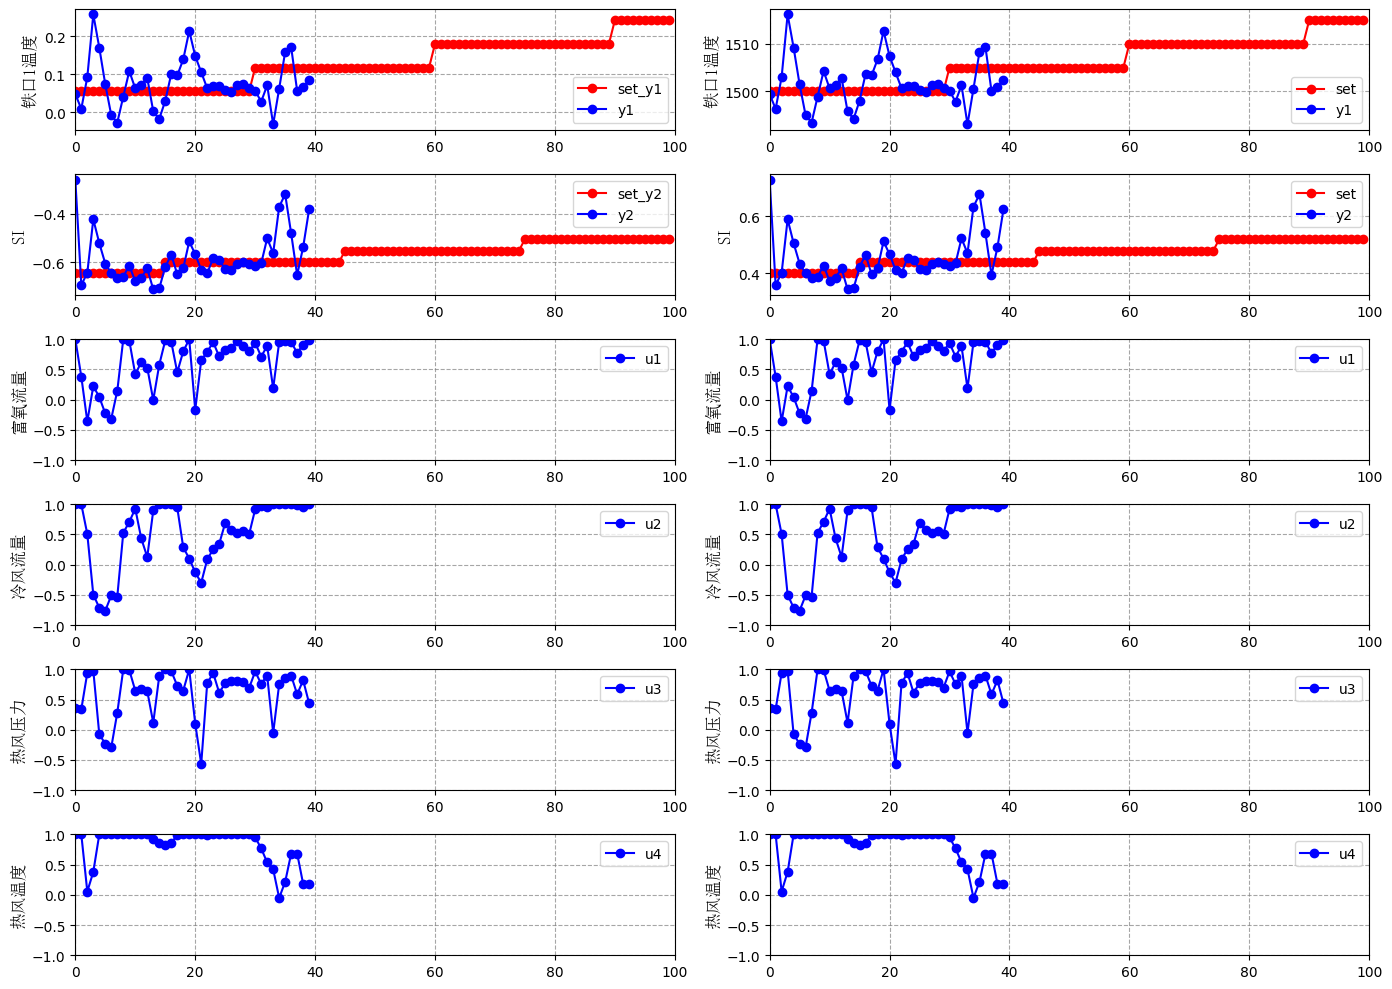

In [66]:
# 模型预测控制结果可视化
# 创建两个子图，分别绘制每个维度
if iscontrol == True:
    plt.figure(figsize=(14, 10))
    
    # 第一个维度的曲线
    plt.subplot(6, 2, 1)
    plt.plot(set_y1_trans, 'ro-', label='set_y1')
    plt.plot(all_pred_y1, 'bo-', label='y1')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第二个维度的曲线
    plt.subplot(6, 2, 3)
    plt.plot(set_y2_trans, 'ro-', label='set_y2')
    plt.plot(all_pred_y2, 'bo-', label='y2')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第一个维度的u1曲线
    plt.subplot(6, 2, 5)
    plt.plot(all_pred_u1, 'bo-', label='u1')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[0], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第二个维度的u2曲线
    plt.subplot(6, 2, 7)
    plt.plot(all_pred_u2, 'bo-', label='u2')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[1], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第三个维度的u3曲线
    plt.subplot(6, 2, 9)
    plt.plot(all_pred_u3, 'bo-', label='u3')  # 修改标签为 'u3'
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[2], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第四个维度的u4曲线
    plt.subplot(6, 2, 11)
    plt.plot(all_pred_u4, 'bo-', label='u4')  # 修改标签为 'u4'
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[3], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')



    ######################################################

    # 第一个维度的曲线
    plt.subplot(6, 2, 2)
    plt.plot(set_y1, 'ro-', label='set')
    plt.plot(y1_pred_inverse_transform, 'bo-', label='y1')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylabel(output_term[0], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第二个维度的曲线
    plt.subplot(6, 2, 4)
    plt.plot(set_y2, 'ro-', label='set')
    plt.plot(y2_pred_inverse_transform, 'bo-', label='y2')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylabel(output_term[1], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第一个维度的u1曲线
    plt.subplot(6, 2, 6)
    plt.plot(all_pred_u1, 'bo-', label='u1')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[0], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第二个维度的u2曲线
    plt.subplot(6, 2, 8)
    plt.plot(all_pred_u2, 'bo-', label='u2')
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[1], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第三个维度的u3曲线
    plt.subplot(6, 2, 10)
    plt.plot(all_pred_u3, 'bo-', label='u3')  # 修改标签为 'u3'
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[2], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')

    # 第四个维度的u4曲线
    plt.subplot(6, 2, 12)
    plt.plot(all_pred_u4, 'bo-', label='u4')  # 修改标签为 'u4'
    plt.axvline(x=0, color='gray', linestyle='--', linewidth=1.5)
    plt.xlim((0,Times))
    plt.ylim((-max_control,max_control))
    plt.ylabel(input_term[3], fontproperties=font)  # 使用中文标签
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7, color='gray')






    # 调整子图布局
    plt.tight_layout()
    plt.show()
